In [37]:
import requests
import pandas as pd

# NYC Open Data API endpoint
base_url = "https://data.cityofnewyork.us/resource/pvqr-7yc4.json"

# Settings
limit = 50000         # Rows per request
offset = 0            # Starting index
max_records = 200000 # Total you want

# Container for all records
data = []

while offset < max_records:
    params = {
        "$limit": limit,
        "$offset": offset
    }

    response = requests.get(base_url, params=params)

    if response.status_code != 200:
        print(f"Request failed at offset {offset} with status code {response.status_code}")
        break

    batch = response.json()

    if not batch:
        print("No more data returned.")
        break

    data.extend(batch)
    offset += limit

    print(f"✅ Retrieved {len(batch)} records (Total so far: {len(data)})")

# Convert to DataFrame
df = pd.DataFrame(data)

df = df.dropna(subset=['house_number', 'street_name', 'violation_county'])

df.to_csv("nyc_parking_violations_sample.csv", index=False)

print("📦 Done! Saved 200.000 rows to nyc_parking_violations_sample.csv")


✅ Retrieved 50000 records (Total so far: 50000)
✅ Retrieved 50000 records (Total so far: 100000)
✅ Retrieved 50000 records (Total so far: 150000)
✅ Retrieved 50000 records (Total so far: 200000)


In [35]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# NYC Open Data API endpoint
base_url = "https://data.cityofnewyork.us/resource/pvqr-7yc4.json"
csv_path = "data/nyc_parking_violations_sample.csv"

# Load existing data
existing_df = pd.read_csv(csv_path, low_memory=False)
existing_ids = set(existing_df['summons_number'])

# Target months: 2022 and 2023 only
target_months = [
    (year, f"{month:02d}")
    for year in [2022, 2023]
    for month in range(1, 13)
]

n_per_month = 3000
total_added = 0

for year, month in target_months:
    start_date = f"{year}-{month}-01T00:00:00.000"
    end_dt = (datetime(int(year), int(month), 1) + timedelta(days=32)).replace(day=1) - timedelta(days=1)
    end_date = end_dt.strftime("%Y-%m-%dT23:59:59.999")

    print(f"\n📅 Fetching up to {n_per_month} fines from {year}-{month}")

    params = {
        "$limit": n_per_month,
        "$order": "issue_date DESC",
        "$where": f"issue_date >= '{start_date}' AND issue_date <= '{end_date}'"
    }

    response = requests.get(base_url, params=params)
    if response.status_code != 200:
        print(f"❌ Request failed for {year}-{month}: {response.status_code}")
        continue

    batch = response.json()
    if not batch:
        print("🚫 No data found for this month.")
        continue

    new_df = pd.DataFrame(batch)
    new_df = new_df[~new_df['summons_number'].isin(existing_ids)]

    if new_df.empty:
        print("⚠️ All rows already in dataset.")
        continue

    existing_df = pd.concat([existing_df, new_df], ignore_index=True)
    existing_ids.update(new_df['summons_number'])
    total_added += len(new_df)

    print(f"✅ Added {len(new_df):,} new rows")

# Save updated dataset
existing_df.to_csv(csv_path, index=False)
print(f"\n💾 Final dataset saved with {len(existing_df):,} rows")
print(f"🆕 {total_added:,} new rows added from 2022–2023.")



📅 Fetching up to 3000 fines from 2022-01
✅ Added 6 new rows

📅 Fetching up to 3000 fines from 2022-02
✅ Added 7 new rows

📅 Fetching up to 3000 fines from 2022-03
✅ Added 1 new rows

📅 Fetching up to 3000 fines from 2022-04
✅ Added 9 new rows

📅 Fetching up to 3000 fines from 2022-05
✅ Added 8 new rows

📅 Fetching up to 3000 fines from 2022-06
✅ Added 52 new rows

📅 Fetching up to 3000 fines from 2022-07
✅ Added 62 new rows

📅 Fetching up to 3000 fines from 2022-08
✅ Added 42 new rows

📅 Fetching up to 3000 fines from 2022-09
✅ Added 49 new rows

📅 Fetching up to 3000 fines from 2022-10
✅ Added 40 new rows

📅 Fetching up to 3000 fines from 2022-11
✅ Added 39 new rows

📅 Fetching up to 3000 fines from 2022-12
✅ Added 35 new rows

📅 Fetching up to 3000 fines from 2023-01
✅ Added 685 new rows

📅 Fetching up to 3000 fines from 2023-02
✅ Added 156 new rows

📅 Fetching up to 3000 fines from 2023-03
✅ Added 181 new rows

📅 Fetching up to 3000 fines from 2023-04
✅ Added 215 new rows

📅 Fetchi

/var/folders/0q/x2dyyz5d7xs7zzrfhj8l86840000gp/T/ipykernel_9646/2506126828.py:26: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/aya/Desktop/Skole/NYC_Project/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


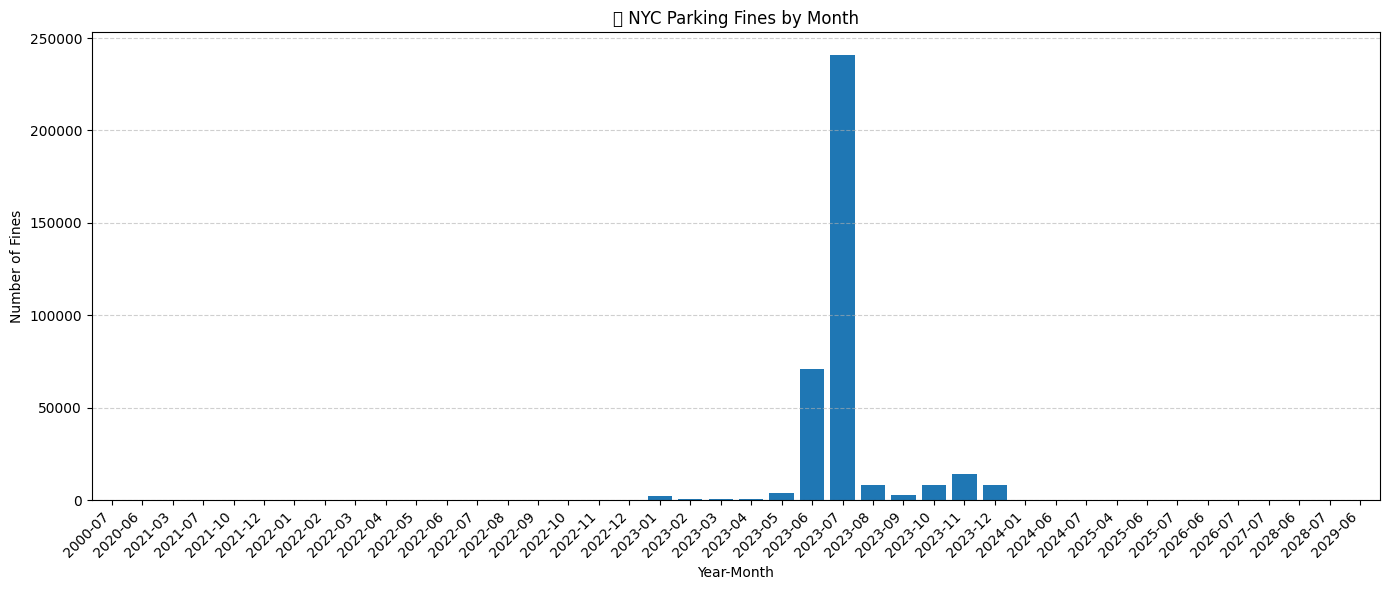

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("data/nyc_parking_violations_sample.csv", low_memory=False)

# Convert issue_date to datetime
df['issue_date'] = pd.to_datetime(df['issue_date'], errors='coerce')

# Drop rows with missing/invalid dates
df = df.dropna(subset=['issue_date'])

# Create year-month column
df['year_month'] = df['issue_date'].dt.to_period('M')

# Count number of fines per month
monthly_counts = df['year_month'].value_counts().sort_index()

# Plot
plt.figure(figsize=(14, 6))
monthly_counts.plot(kind='bar', width=0.8)
plt.title("🗓️ NYC Parking Fines by Month")
plt.xlabel("Year-Month")
plt.ylabel("Number of Fines")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()
